In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Setup

In [2]:
import os
import pandas as pd
import ffmpeg
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from src.dataset import DATASET_FEATURES

In [125]:
AUDIOS_DIR_PATH = "res/mp3_data"
CSV_PATH = "res/samples.csv"
PROCESSED_CSV_PATH = "res/samples_processed.csv"
CLUSTERED_CSV_PATH = "res/samples_clustered.csv"
DATASETS_DIR_PATH = "res/datasets"

# Dataset Exploration

In [4]:
df = pd.read_csv(CSV_PATH)

print(f"The dataset contains {len(df)} audio files")
df.head()

The dataset contains 29220 audio files


path    genre          category  \
0        01 Hip Hop/Abandoned Brass Stabs.caf  Hip Hop           Trumpet   
1  01 Hip Hop/Abandoned Orchestral Layers.caf  Hip Hop           Timpani   
2                  01 Hip Hop/Afloat Beat.caf  Hip Hop  Electronic Beats   
3                   01 Hip Hop/Afloat Pad.caf  Hip Hop       Synthesizer   
4              01 Hip Hop/Afloat Sub Bass.caf  Hip Hop    Synthetic Bass   

        subcategory key type key signature time signature  beat count  Single  \
0           Trumpet    minor             E            4/4         8.0    True   
1           Timpani    minor             E            4/4        16.0   False   
2  Electronic Beats      NaN           NaN            4/4        32.0    True   
3       Synthesizer    minor             C            4/4        32.0    True   
4    Synthetic Bass    minor             C            4/4        32.0    True   

   Ensemble  ...  Electric  Melodic  Dissonant  Relaxed  Intense  Part   Fill  \
0     False  ...      True     True      False    False    False  True  False   
1      True  ...      True    False      False    False     True  True  False   
2     False  ...      True    False      False    False    False  True  False   
3     False  ...      True     True      False     True    False  True  False   
4     False  ...      True     True      False    False    False  True  False   

   Cheerful   Dark   duration  
0     False   True   7.262041  
1     False   True  14.445714  
2     False  False  19.670204  
3     False  False  19.670204  
4     False  False  19.670204  

[5 rows x 27 columns]

## Audio Files

First, I replace the extension as the source file are listed a `.caf`, while I'm using `.mp3`

In [5]:
df["path"] = df["path"].apply(lambda x: x.replace(".caf", ".mp3"))

I then collect and plot the duration of each mp3 file to get an understanding of the size of the dataset

In [6]:
df["id"] = df["path"].apply(
    lambda x: "_".join(".".join(x.split(".")[:-1]).replace("/", " ").split(" "))
)

In [10]:
durations = []
for path in tqdm(df["path"]):
    out = ffmpeg.probe(os.path.join(AUDIOS_DIR_PATH, path))
    dur = out['format']['duration']
    durations.append(float(dur))
    
df["duration"] = durations

100%|██████████| 29220/29220 [1:04:06<00:00,  7.60it/s]


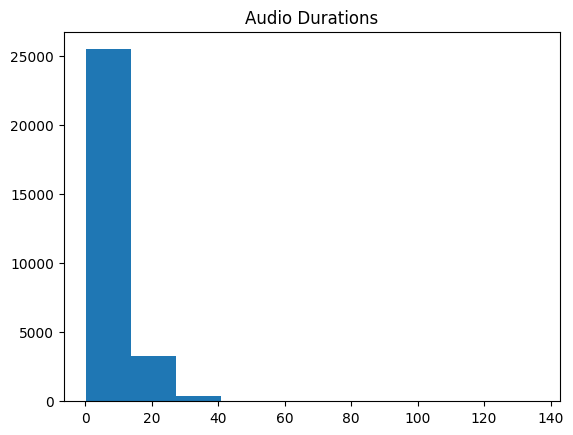

In [7]:
data, bins = np.histogram(df["duration"])

plt.hist(df["duration"], bins=bins) 
plt.title("Audio Durations") 
plt.show()

The great majority of the examples have a duration under 30 seconds, as a starting criterion, we could safely filter out longer samples from the dataset as they're a very little portion of the whole and may slow down every computation

or

Since the task is computing intense and there are a LOT of small samples, I'll filter out everything longer then 10 seconds

In [8]:
df = df[df["duration"] < 10]
print(f"{len(df)} examples left")

21886 examples left


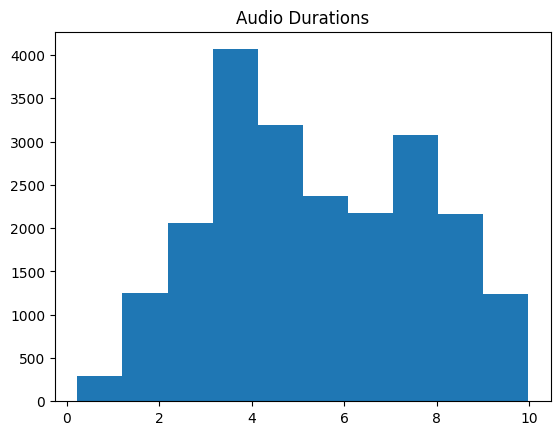

In [9]:
data, bins = np.histogram(df["duration"])

plt.hist(df["duration"], bins=bins) 
plt.title("Audio Durations") 
plt.show()

Save the updated DataFrame into a new file:

In [10]:
df.to_csv(PROCESSED_CSV_PATH, index=False)

## Classes

In [82]:
df = pd.read_csv(PROCESSED_CSV_PATH)

The dataset contains various features, this work focuses on `genre` and `category`, so it makes sense to filter out rows containing no value for those two columns

In [83]:
drop_features = [f for f in DATASET_FEATURES if f not in ["genre", "category"] and f in df.columns]
df = df.drop(columns=drop_features)
df = df[~df.isna().any(axis=1)]
print(f"{len(df)} examples left")
df.head()

20636 examples left


path    genre     category  \
0          01 Hip Hop/Abandoned Brass Stabs.mp3  Hip Hop      Trumpet   
1              01 Hip Hop/Against Time Keys.mp3  Hip Hop  Synthesizer   
2             01 Hip Hop/Against Time Piano.mp3  Hip Hop        Piano   
3        01 Hip Hop/Against Time Sax Sample.mp3  Hip Hop    Saxophone   
4  01 Hip Hop/Against Time Staccato Strings.mp3  Hip Hop        Cello   

   duration                                        id  
0  7.262041          01_Hip_Hop_Abandoned_Brass_Stabs  
1  6.948571              01_Hip_Hop_Against_Time_Keys  
2  6.948571             01_Hip_Hop_Against_Time_Piano  
3  6.948571        01_Hip_Hop_Against_Time_Sax_Sample  
4  6.948571  01_Hip_Hop_Against_Time_Staccato_Strings

### Genre

Genre
--------------------------------------------------
count      31.000000
mean      665.677419
std       872.958891
min        12.000000
25%       222.500000
50%       320.000000
75%       653.500000
max      3465.000000
dtype: float64


<Axes: xlabel='genre'>

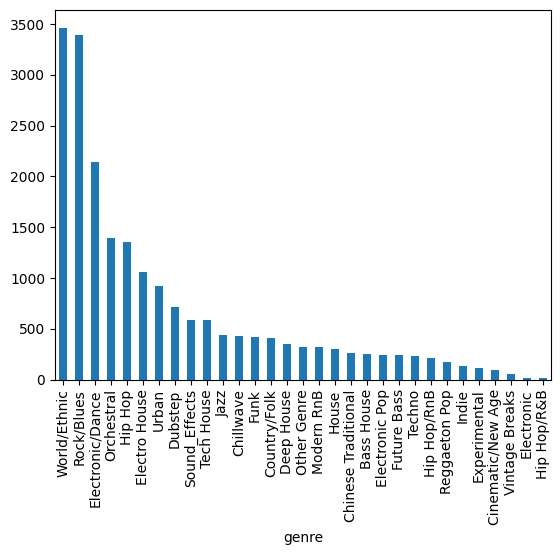

In [84]:
genre_counts = df.value_counts("genre")

print("="*50)
print("Genre")
print("-"*50)
print(genre_counts.describe())

genre_counts.plot(kind='bar')

Yada yada yada

In [85]:
def invert_dict(clusters):
    clusters_map = {}
    for k, v in clusters.items():
        for vx in v:
            clusters_map[vx] = k
    return clusters_map

genre_clusters = {
    "World/Ethnic": ["World/Ethnic", "Chinese Traditional"],
    "Hip Hop/RnB": ["Hip Hop/RnB", "Hip Hop/R&B", "Hip Hop", "Modern RnB", "Urban"],
    "Electronic": ["Electronic", "Electronic/Dance", "Chillwave", "Electronic Pop", "Techno"],
    "House": ["House", "Bass House", "Deep House", "Tech House", "Electro House"],
}

df["cluster_genre"] = df["genre"].replace(invert_dict(GENRE_CLUSTERS))
genre_counts = df["cluster_genre"].value_counts()
genre_counts

World/Ethnic         3722
Rock/Blues           3391
Electronic           3063
Hip Hop/RnB          2818
House                2543
Orchestral           1395
Dubstep               716
Sound_Effects         591
Jazz                  438
Funk                  421
Country/Folk          408
Other Genre           320
Future Bass           239
Reggaeton Pop         173
Indie                 135
Experimental          114
Cinematic/New Age      90
Vintage Breaks         59
Name: cluster_genre, dtype: int64

Take only the first 6

<Axes: >

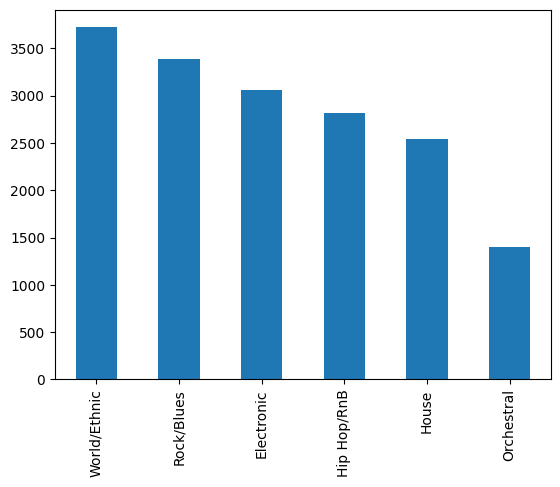

In [86]:
TOP_N_GENRES = 6
selected_genre_counts = genre_counts[:TOP_N_GENRES]
selected_genre_counts.plot(kind='bar')

### Category

In [87]:
category_counts = df.value_counts("category")

print("="*50)
print("Category")
print("-"*50)
print(category_counts.describe())

Category
--------------------------------------------------
count      69.000000
mean      299.072464
std       591.610000
min         1.000000
25%         6.000000
50%        30.000000
75%       176.000000
max      2859.000000
dtype: float64


<Axes: xlabel='category'>

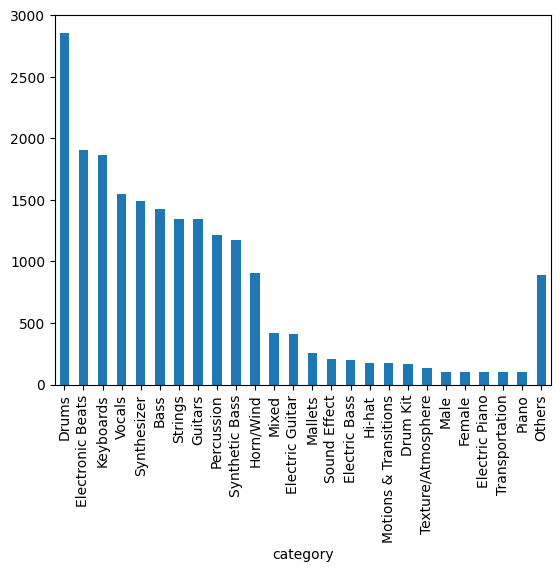

In [88]:
grouped_categories = category_counts[category_counts < 100]
category_counts = category_counts.drop(grouped_categories.index)
category_counts["Others"] = grouped_categories.sum()

category_counts.plot(kind='bar')

In [89]:
category_clusters = {
    "Drums": ["Drums", "Drum Kit"],
    "Bass": ["Bass", "Synthetic Bass", "Electric Bass"],
    "Guitars": ["Guitars", "Electric Guitar"],
    "Keyboards/Synths": ["Keyboards", "Piano", "Electric Piano", "Synthesizer"],
    "Vocals": ["Vocals", "Female", "Male"],
}

df["cluster_category"] = df["category"].replace(invert_dict(CATEGORY_CLUSTERS))
category_counts = df["cluster_category"].value_counts()
category_counts[:20]

Keyboards                3566
Drums                    3026
Bass                     2796
Electronic Beats         1906
Vocals                   1762
Guitars                  1755
Strings                  1347
Percussion               1216
Horn/Wind                 906
Mixed                     416
Mallets                   255
Sound Effect              205
Hi-hat                    179
Motions & Transitions     176
Texture/Atmosphere        135
Transportation            100
Kick                       99
Animals                    98
Other Instrument           87
Snare                      75
Name: cluster_category, dtype: int64

<Axes: >

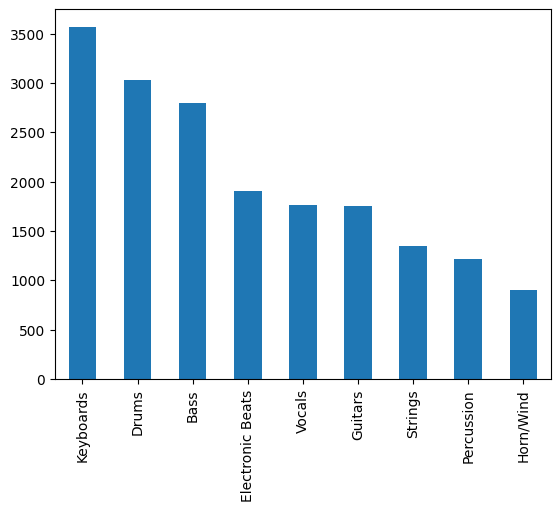

In [90]:
TOP_N_CATEGORIES = 9
selected_category_counts = category_counts[:TOP_N_CATEGORIES]
selected_category_counts.plot(kind='bar')

In [92]:
df.drop(columns=["genre", "category"]).rename(
    columns={"cluster_genre": "genre", "cluster_category": "category"}
).to_csv(CLUSTERED_CSV_PATH, index=False)

## Samples

In [93]:
df = pd.read_csv(CLUSTERED_CSV_PATH)

In [107]:
from src.dataset import get_dataset, add_audio_column
from src.utils import play_audios_by_id

ds = get_dataset(df)

# Reference sampling rate will always be 16kHz
ds = add_audio_column(ds, AUDIOS_DIR_PATH, sampling_rate=16_000)
ds

Dataset({
    features: ['path', 'duration', 'id', 'genre', 'category', 'audio'],
    num_rows: 20636
})

In [96]:
for genre in selected_genre_counts.index:
    df_subset = df[df["genre"] == genre]
    print("="*50)
    print(genre)
    print("-"*50)
    play_audios_by_id(ds, df_subset.sample(2)["id"], print_features=["id", "duration"])

World/Ethnic
--------------------------------------------------
id: 12_Chinese_Traditional_Jiangnan_Mist_and_Rain_Guzheng_02 - duration: 7.497143


id: Jam_Pack_World_Music_Bosnian_Sunset_Bass_01 - duration: 4.440816


Rock/Blues
--------------------------------------------------
id: Jam_Pack_Rhythm_Section_Groove_Along_Rock_Bass_07 - duration: 4.257959


id: 11_Blues_Garage_Descending_Blues_Bass_01 - duration: 8.803265


Electronic
--------------------------------------------------
id: 03_Dubstep_Dubstep_Topper_01 - duration: 3.526531


id: 07_Chillwave_Downtown_Scene_Beat_02 - duration: 4.884898


Hip Hop/RnB
--------------------------------------------------
id: 01_Hip_Hop_M_Style_Guitar_01 - duration: 6.50449


id: Jam_Pack_Voices_Nathan_Lyric_39 - duration: 5.877551


House
--------------------------------------------------
id: 02_Electro_House_Subsonic_Bass - duration: 7.601633


id: Backlight_Bounce_Low_Whisper_Beat - duration: 7.601633


Orchestral
--------------------------------------------------
id: Jam_Pack_Symphony_Orchestra_Classical_Waltz_Piano_03 - duration: 3.709388


id: Jam_Pack_Voices_Boys_Choir_Background_07 - duration: 5.903673


In [97]:
for category in selected_category_counts.index:
    df_subset = df[df["category"] == category]
    print("="*50)
    print(category)
    print("-"*50)
    play_audios_by_id(ds, df_subset.sample(1)["id"], print_features=["id", "duration"])

Keyboards
--------------------------------------------------
id: 01_Hip_Hop_Left_Coast_High_Synth - duration: 6.50449


Drums
--------------------------------------------------
id: Jam_Pack_Remix_Tools_House_Hands_Together_Beat - duration: 3.94449


Bass
--------------------------------------------------
id: 15_Reggaeton_Pop_Solid_Gold_Synth_Bass_01 - duration: 5.433469


Electronic Beats
--------------------------------------------------
id: 05_Tech_House_Skippy_Hat_Topper - duration: 3.94449


Vocals
--------------------------------------------------
id: Jam_Pack_Voices_Nathan_Lyric_17 - duration: 4.388571


Guitars
--------------------------------------------------
id: Jam_Pack_World_Music_Brazilian_Sun_Guitar_03 - duration: 4.257959


Strings
--------------------------------------------------
id: Jam_Pack_World_Music_Beltane_Celtic_Harp_04 - duration: 7.444898


Percussion
--------------------------------------------------
id: Jam_Pack_World_Music_Latin_Day_Timbale_04 - duration: 3.291429


Horn/Wind
--------------------------------------------------
id: Apple_Loops_for_GarageBand_Latin_Horn_Stabs_03 - duration: 4.257959


## Feature Extraction

In this work, two different yada are taken into account:

In [116]:
from src.train import get_preprocess_func

rand_idx = np.random.choice(range(len(ds)), 3, replace=False)
ds_sample = ds.select(rand_idx)
ds_sample

Dataset({
    features: ['path', 'duration', 'id', 'genre', 'category', 'audio'],
    num_rows: 3
})

### Normalized Wave

In [117]:
wav2vec2_encode = get_preprocess_func({
    "feature_encoder": "wav2vec2"
})

In [118]:
ds_norm = ds_sample.map(wav2vec2_encode, batched=True)
ds_norm

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['path', 'duration', 'id', 'genre', 'category', 'audio', 'input_values'],
    num_rows: 3
})

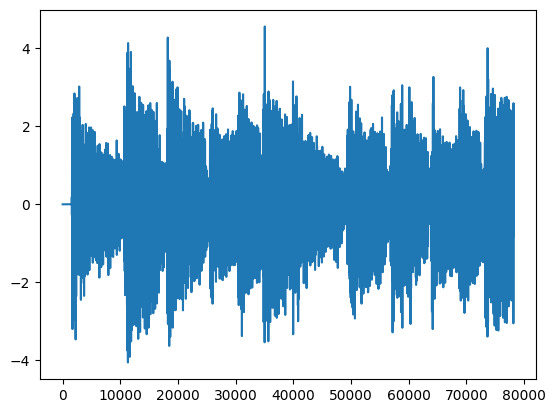

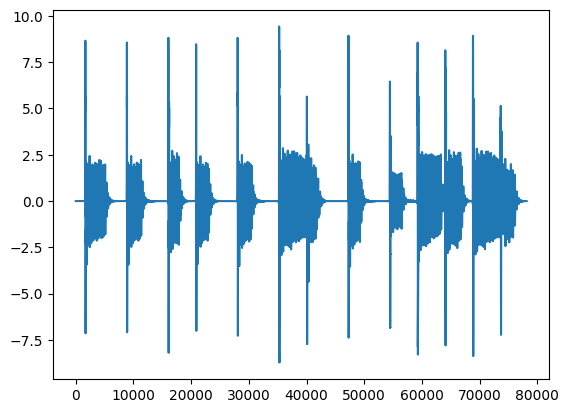

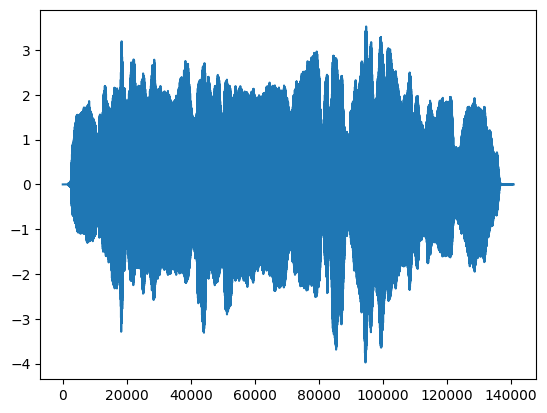

In [119]:
from src.utils import play_audio

for values, audio in zip(ds_norm["input_values"], ds_norm["audio"]):
    plt.plot(values)
    plt.show()
    play_audio(audio)


In [127]:
import datasets

encoded_dataset_path = os.path.join(DATASETS_DIR_PATH, "ds-wav2vec2-full-encoded")

# If not already created in a previous run, use Hugging Face `datasets` library to encode every sample
# for the Wav2Vec2 model

if os.path.exists(encoded_dataset_path):
    ds = datasets.load_from_disk(encoded_dataset_path)
else:
    non_encoded_ds = get_dataset(df)
    non_encoded_ds = add_audio_column(non_encoded_ds, audios_dir_path=AUDIOS_DIR_PATH, training_config=TRAINING_CONFIG)
    print("Applying preprocessing to dataset")
    ds = non_encoded_ds.map(wav2vec2_encode, remove_columns=["audio"], batched=True)
    ds.save_to_disk(encoded_dataset_path)

ds

Dataset({
    features: ['path', 'genre', 'category', 'id', 'duration', 'input_values'],
    num_rows: 20636
})

### Mel-Spectrogram

In [120]:
whisper_encode = get_preprocess_func({
    "feature_encoder": "whisper"
})

In [121]:
ds_spectrogram = ds_sample.map(whisper_encode, batched=True)
ds_spectrogram

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['path', 'duration', 'id', 'genre', 'category', 'audio', 'input_features'],
    num_rows: 3
})

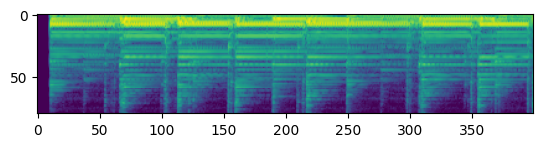

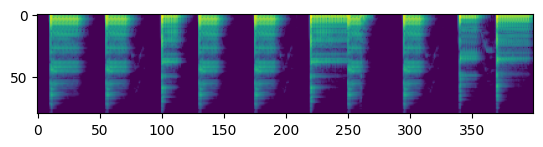

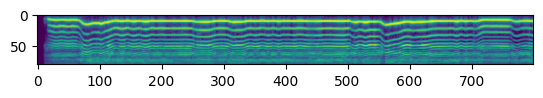

In [123]:
def trim_trail(spectrogram, audio):
    spectrogram = np.array(spectrogram)
    samples = len(audio["array"]) // audio["sampling_rate"] * 100
    return spectrogram[:,:samples]

for values, audio in zip(ds_spectrogram["input_features"], ds_spectrogram["audio"]):
    play_audio(audio)
    plt.imshow(trim_trail(values, audio))
    plt.show()

In [128]:
encoded_dataset_path = os.path.join(DATASETS_DIR_PATH, "ds-whisper-full-encoded")

# Same process applied before repeated again, for computing Mel-Spectrograms for the Whisper model

if os.path.exists(encoded_dataset_path):
    ds = datasets.load_from_disk(encoded_dataset_path)
else:
    non_encoded_ds = get_dataset(df)
    non_encoded_ds = add_audio_column(non_encoded_ds, audios_dir_path=AUDIOS_DIR_PATH, training_config=TRAINING_CONFIG)
    print("Applying preprocessing to dataset")
    ds = non_encoded_ds.map(whisper_encode, remove_columns=["audio"], batched=True)
    ds.save_to_disk(encoded_dataset_path)

ds

Dataset({
    features: ['path', 'genre', 'category', 'id', 'duration', 'input_features'],
    num_rows: 20636
})